In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm.notebook import tqdm
import numpy as np
from collections import deque

In [46]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 100

#max steps per episode
MAX_STEPS = 5000

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda


In [47]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [48]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [49]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [50]:
#Make environment
env = gym.make('CliffWalking-v0',  render_mode="rgb_array")
#Init network
policy_network = PolicyNetwork(env.observation_space.n, env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.n).to(DEVICE)

#Init optimizer
policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)

In [51]:
def int_to_one_hot(state_int, num_states=env.observation_space.n):
    one_hot_array = np.zeros(num_states, dtype=np.float32)
    one_hot_array[state_int] = 1.0
    return one_hot_array

In [52]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in tqdm(range(NUM_EPISODES)):

    #init variables
    state = env.reset()[0]
    state = int_to_one_hot(state)
    done = False
    score = 0
    I = 1

    #run episode, update online
    for step in range(MAX_STEPS):
        env.render()
        #get action and log probability
        action, lp = select_action(policy_network, state)
        #step with action
        step_result = env.step(action)
        new_state, reward, done, _ = step_result[:4]
        print("episode:", episode, "step:", step, "new_state:", new_state, "done:" ,done)
        
        new_state = int_to_one_hot(new_state)
        #update episode score
        score += reward

        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)

        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)
        new_state_val = stateval_network(new_state_tensor)

        #calculate value function loss with MSE
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I

        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I

        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()

        if done:
            break

        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR

    #append episode score
    scores.append(score)
    recent_scores.append(score)



  0%|          | 0/50 [00:00<?, ?it/s]

episode: 0 step: 0 new_state: 24 done: False
episode: 0 step: 1 new_state: 36 done: False
episode: 0 step: 2 new_state: 24 done: False
episode: 0 step: 3 new_state: 12 done: False
episode: 0 step: 4 new_state: 12 done: False
episode: 0 step: 5 new_state: 24 done: False


c:\Users\aacic\anaconda3\envs\reinforce_lab10\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0 step: 6 new_state: 24 done: False
episode: 0 step: 7 new_state: 24 done: False
episode: 0 step: 8 new_state: 25 done: False
episode: 0 step: 9 new_state: 13 done: False
episode: 0 step: 10 new_state: 25 done: False
episode: 0 step: 11 new_state: 26 done: False
episode: 0 step: 12 new_state: 25 done: False
episode: 0 step: 13 new_state: 36 done: False
episode: 0 step: 14 new_state: 24 done: False
episode: 0 step: 15 new_state: 12 done: False
episode: 0 step: 16 new_state: 0 done: False
episode: 0 step: 17 new_state: 0 done: False
episode: 0 step: 18 new_state: 12 done: False
episode: 0 step: 19 new_state: 0 done: False
episode: 0 step: 20 new_state: 12 done: False
episode: 0 step: 21 new_state: 13 done: False
episode: 0 step: 22 new_state: 25 done: False
episode: 0 step: 23 new_state: 24 done: False
episode: 0 step: 24 new_state: 24 done: False
episode: 0 step: 25 new_state: 24 done: False
episode: 0 step: 26 new_state: 25 done: False
episode: 0 step: 27 new_state: 13 done: F

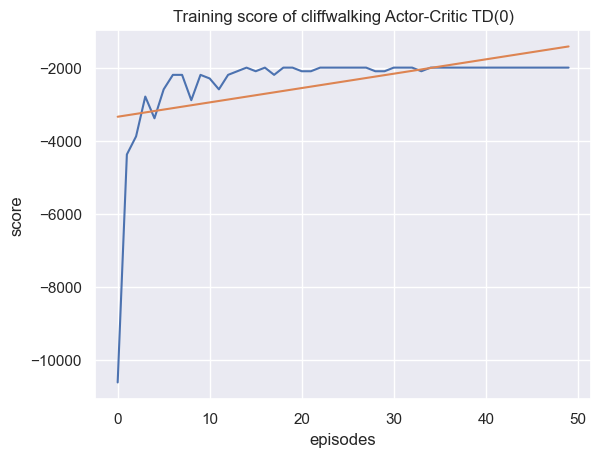

In [53]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of cliffwalking Actor-Critic TD(0)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [54]:
scores = []
state = env.reset()[0]
NUM_EPISODES = 50

for episode in range(NUM_EPISODES):
    done = False
    score = 0
    while not done:
        state = int_to_one_hot(state)
        env.render()
        action, lp = select_action(policy_network, state)
        new_state, reward, done, info = env.step(action)[:4]
        score += reward
        state = new_state
    scores.append(score)
env.close()

KeyboardInterrupt: 

In [ ]:
env.close()

In [ ]:
np.array(scores).mean()

-10.0